<a href="https://colab.research.google.com/github/samkrem/ACL_UWB_Pose_Estimation_Research_Project/blob/main/Noise_Prediction_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.distributions as distributions
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from pathlib import Path
from itertools import product

import pandas as pd

In [ ]:
#If importing from google drive/using google colab
from google.colab import drive

drive.mount('/content/gdrive')
file_path_on_drive = '/content/gdrive/My Drive/ACL_UWB_NN_models/Uniform(min=-0.1, max=0.1).csv'
df = pd.read_csv(file_path_on_drive)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Importing from desktop
from google.colab import files
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['~/.csv']), skiprows=1)

KeyboardInterrupt: 

In [ ]:
csv_values= df.values
x_poses=csv_values[:, :6]
z_true=csv_values[:,6]
w_x=csv_values[:,7]
z_x=csv_values[:,8]


In [ ]:
z_x=z_x.reshape(-1,1)
xz_input=np.hstack((x_poses, z_x))

w_x=w_x.reshape(-1,1)

In [ ]:
xz_input=xz_input.astype(np.float32)
print(f"xz_input numpy array dtype: {xz_input.dtype}")
print(f"xz_input.shape: {xz_input.shape}")
w_x = w_x.astype(np.float32)

print(f"w_x numpy array dtype: {w_x.dtype}")
print(f"w_x.shape: {w_x.shape}")


xz_input numpy array dtype: float32
xz_input.shape: (3375000, 7)
w_x numpy array dtype: float32
w_x.shape: (3375000, 1)


In [ ]:
z_x_graph=z_x.reshape(-1)

z_x_graph=z_x_graph.astype(np.float32)

w_x_graph=w_x.reshape(-1)
w_x_graph=list(w_x_graph.astype(np.float32))





Text(0.5, 1.0, 'Sampled Noise (w(x)) Histogram')

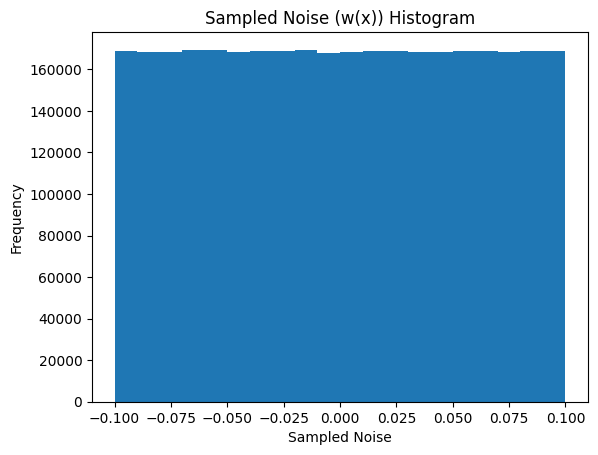

In [ ]:
plt.hist(w_x,20)
plt.xlabel("Sampled Noise")
plt.ylabel("Frequency")
plt.title("Sampled Noise (w(x)) Histogram")


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
xz_train, xz_temp, w_x_train, w_x_temp = train_test_split(xz_input, w_x, test_size=0.3, random_state=42)
xz_val, xz_test, w_x_val, w_x_test = train_test_split(xz_temp, w_x_temp, test_size=0.5, random_state=42)


In [ ]:
xz_pose_train_scaled_tensor = torch.tensor(xz_train, dtype=torch.float32, device=device)
xz_pose_valid_scaled_tensor = torch.tensor(xz_val, dtype=torch.float32, device=device)
xz_pose_test_scaled_tensor = torch.tensor(xz_test, dtype=torch.float32, device=device)

print("X Pose, Z Scalar Distance Train Tensor Shape:", xz_pose_train_scaled_tensor.shape)
print("X Pose, Z Scalar Validation Tensor Shape:", xz_pose_valid_scaled_tensor.shape)
print("X Pose, Z Scalar Test Tensor Shape:", xz_pose_test_scaled_tensor.shape)


w_x_train_tensor = torch.tensor(w_x_train, dtype=torch.float32, device=device)
w_x_valid_tensor = torch.tensor(w_x_val, dtype=torch.float32, device=device)

w_x_test_tensor = torch.tensor(w_x_test, dtype=torch.float32, device=device)

print("w(x) Train Tensor Shape:", w_x_train_tensor.shape)
print("w(x) Validation Tensor Shape:", w_x_valid_tensor.shape)
print("w(x) Test Tensor Shape:", w_x_test_tensor.shape)

X Pose, Z Scalar Distance Train Tensor Shape: torch.Size([2362500, 7])
X Pose, Z Scalar Validation Tensor Shape: torch.Size([506250, 7])
X Pose, Z Scalar Test Tensor Shape: torch.Size([506250, 7])
w(x) Train Tensor Shape: torch.Size([2362500, 1])
w(x) Validation Tensor Shape: torch.Size([506250, 1])
w(x) Test Tensor Shape: torch.Size([506250, 1])


In [ ]:
class NoisePredictionModel(nn.Module):
    #in_features: UWB change in pose and true distance of two robots
    #Hidden Layer 1: # of neurons
    #Hidden Layer 2: neurons
    #Output layer: UWB Sensor Noise
    def __init__(self, in_features=7, h1=256, h2=128, h3=64, h4=32, out_features=1, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1) #trial and error, adjust/look at hyperparameters
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(h1, h2)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3=nn.Linear(h2,h3)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.fc4=nn.Linear(h3,h4)


        self.out = nn.Linear(h4, out_features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x=torch.relu(self.fc3(x))
        x=self.dropout3(x)
        x=torch.relu(self.fc4(x))
        x = self.out(x)
        return x

In [ ]:
model = NoisePredictionModel()
model.to(device)

fc1_weight_shape = model.state_dict()["fc1.weight"].shape
fc1_bias_shape = model.state_dict()["fc1.bias"].shape

fc2_weight_shape = model.state_dict()["fc2.weight"].shape
fc2_bias_shape = model.state_dict()["fc2.bias"].shape

fc3_weight_shape = model.state_dict()["fc3.weight"].shape
fc3_bias_shape = model.state_dict()["fc3.bias"].shape

fc4_weight_shape = model.state_dict()["fc4.weight"].shape
fc4_bias_shape = model.state_dict()["fc4.bias"].shape

out_weight_shape = model.state_dict()["out.weight"].shape
out_bias_shape = model.state_dict()["out.bias"].shape

# Check for dropout layers
dropout1_rate = model.dropout1.p if hasattr(model, 'dropout1') else None
dropout2_rate = model.dropout2.p if hasattr(model, 'dropout2') else None
dropout3_rate = model.dropout3.p if hasattr(model, 'dropout3') else None

print(f"Model state dict keys: {model.state_dict().keys()}")
print(f"fc1 weight shape: {fc1_weight_shape} | fc1 bias shape: {fc1_bias_shape}")
print(f"fc2 weight shape: {fc2_weight_shape} | fc2 bias shape: {fc2_bias_shape}")
print(f"fc3 weight shape: {fc3_weight_shape} | fc3 bias shape: {fc3_bias_shape}")
print(f"fc4 weight shape: {fc4_weight_shape} | fc4 bias shape: {fc4_bias_shape}")

print(f"out weight shape: {out_weight_shape} | out bias shape: {out_bias_shape}")
print(f"Dropout1 rate: {dropout1_rate}")
print(f"Dropout2 rate: {dropout2_rate}")
print(f"Dropout3 rate: {dropout3_rate}")

Model state dict keys: odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'out.weight', 'out.bias'])
fc1 weight shape: torch.Size([256, 7]) | fc1 bias shape: torch.Size([256])
fc2 weight shape: torch.Size([128, 256]) | fc2 bias shape: torch.Size([128])
fc3 weight shape: torch.Size([64, 128]) | fc3 bias shape: torch.Size([64])
fc4 weight shape: torch.Size([32, 64]) | fc4 bias shape: torch.Size([32])
out weight shape: torch.Size([1, 32]) | out bias shape: torch.Size([1])
Dropout1 rate: 0.1
Dropout2 rate: 0.1
Dropout3 rate: 0.1


In [ ]:
loss_fn = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.000004, weight_decay=0.04)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(xz_pose_train_scaled_tensor, w_x_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
epochs = 30
batch_size=64

epoch_count= []

w_x_train_loss_values= []

w_x_valid_loss_values = []

correctd_UWB_pose_test_loss_values = []

print_loss_rate=25


for epoch in range(epochs):
  #Set model to training mode
  model.train()
  for batch_xz_pose_scaled, batch_w_x in train_loader:
  #1. Forward pass
      batch_w_x_scaled_pred= model(batch_xz_pose_scaled) #predicted pose essentially? or is this the error
  #2. Calculate loss
  #WE MUST PUT THE UNSCALE THE PREDICTED DATA SO ITS IN THE ORIGNIAL SCALE OF THE OUTPUT SO OUR LOSS ISN'T FUCKED UP
      loss=loss_fn(batch_w_x_scaled_pred, batch_w_x)
  #3. Zero the gradient
      optimizer.zero_grad()

  #3. Perform backpropogation:
      loss.backward()

  #4. Step the optimizer
      optimizer.step()

  # Validation loop

  model.eval()
  with torch.inference_mode(): #testing the predictions
    w_x_valid_pred=model(xz_pose_valid_scaled_tensor)
    w_x_valid_loss=loss_fn(w_x_valid_pred, w_x_valid_tensor)

  if epoch%1==0: #just to print info
    epoch_count.append(epoch)
    w_x_valid_loss_values.append(w_x_valid_loss.cpu().detach().numpy())
    w_x_train_loss_values.append(loss.cpu().detach().numpy())
    print(f"Epoch:{epoch+1}| Loss: {loss} | Validation loss: {w_x_valid_loss}")


Epoch:1| Loss: 0.0017845570109784603 | Validation loss: 0.0016716406680643559
Epoch:2| Loss: 0.0018724016845226288 | Validation loss: 0.001666996511630714
Epoch:3| Loss: 0.0009347526938654482 | Validation loss: 0.0016667423769831657
Epoch:4| Loss: 0.0015641746576875448 | Validation loss: 0.001666573341935873
Epoch:5| Loss: 0.0022422473412007093 | Validation loss: 0.0016667984891682863
Epoch:6| Loss: 0.0022803826723247766 | Validation loss: 0.0016665443545207381
Epoch:7| Loss: 0.0015099446754902601 | Validation loss: 0.0016665945295244455
Epoch:8| Loss: 0.0014030055608600378 | Validation loss: 0.0016665434231981635
Epoch:9| Loss: 0.00205725384876132 | Validation loss: 0.0016665608854964375
Epoch:10| Loss: 0.0010760386940091848 | Validation loss: 0.0016666239826008677
Epoch:11| Loss: 0.0013776239939033985 | Validation loss: 0.0016665459843352437
Epoch:12| Loss: 0.0017282473854720592 | Validation loss: 0.0016665799776092172
Epoch:13| Loss: 0.0021477346308529377 | Validation loss: 0.001666

In [ ]:
plt.figure()
plt.plot(epoch_count,w_x_valid_loss_values,"b", label="validation")
plt.plot(epoch_count,w_x_train_loss_values,"r", label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()


In [ ]:
model.eval()
with torch.inference_mode():
    # w_x_test_pred = model(xz_pose_test_scaled_tensor)
    w_x_test_pred = model(xz_pose_train_scaled_tensor)
    w_x_test_loss=loss_fn(w_x_test_pred, w_x_train_tensor) #TEST DATA
print(f"Test loss: {w_x_test_loss}")
print(w_x_test_pred)

Test loss: 0.423936128616333
tensor([[-10.7559],
        [ -8.7019],
        [  4.0545],
        ...,
        [ -5.2135],
        [  8.9651],
        [ -1.2877]], device='cuda:0')


In [ ]:
#If test set is satisfactory
model.eval()
with torch.inference_mode():
    w_x_pred = model(torch.tensor(xz_input, dtype=torch.float32).to(device))
    w_x_pred= w_x_pred.cpu().numpy()


# print(w_x_pred.shape)
# print("Corrected UWB Pose      | True Pose")

#z=w_x+h_x #h_x is true distance, z is simulated
# for i in range(w_x_pred.shape[0]):
#       x_pred=w_x_pred[i,0]
#       corr_UWB_rho_disp=w_x_pred[i,1]
#       print(f"{corr_UWB_theta_disp:.2f} \t {corr_UWB_rho_disp:.3f} \t\t|\t{w_x_pred[i,0]} \t {w_x_pred[i,1]}" , end='\t')
#       print()

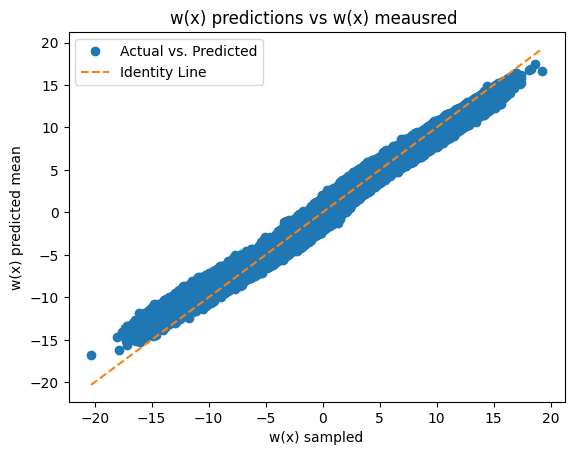

In [ ]:
plt.plot(w_x, w_x_pred, 'o', label='Actual vs. Predicted')
plt.plot([min(w_x), max(w_x)], [min(w_x), max(w_x)], '--', label='Identity Line')

plt.xlabel("w(x) sampled")
plt.ylabel("w(x) predicted mean")
plt.title("w(x) predictions vs w(x) meausred ")
plt.legend()
plt.show()

[-7.8960514]
[-5.3092866]


Text(0.5, 1.0, 'Frequency of Measured w(x)')

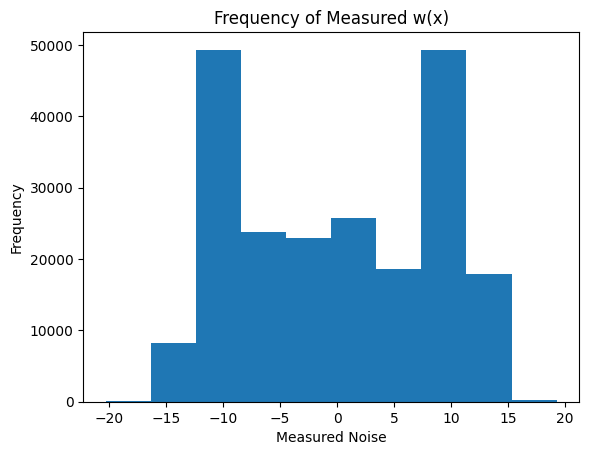

In [ ]:
print(w_x[0])
print(w_x_pred[0])
plt.hist(w_x)
plt.xlabel("Measured Noise")
plt.ylabel("Frequency")
plt.title("Frequency of Measured w(x)")

Text(0.5, 1.0, 'Frequency of Predicted w(x)')

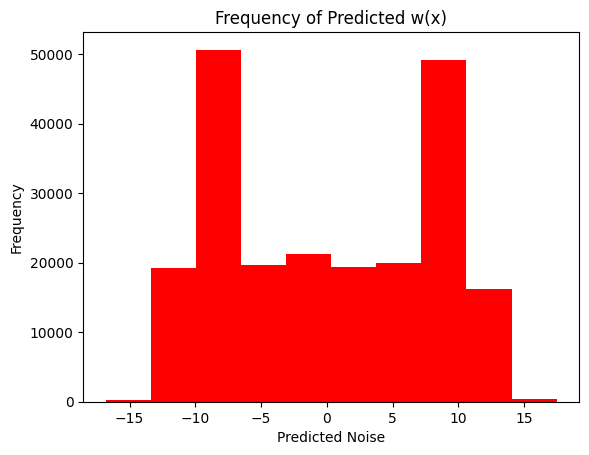

In [ ]:
plt.hist(w_x_pred, color="red")
plt.xlabel("Predicted Noise")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted w(x)")

In [ ]:
parameters=model.state_dict()

weights = [parameters[key] for key in parameters if 'weight' in key]

biases = [parameters[key] for key in parameters if 'bias' in key]
for i in range(len(weights)):
  print(f"Layer {i+1} Weight: \n {weights[i].cpu().numpy()}")
for i in range(len(biases)):
  print(f"Layer {i+1} Bias: \n {biases[i].cpu().numpy()}")


Layer 1 Weight: 
 [[-1.1541375e-01 -3.4959432e-01  1.2922421e-01 ... -2.6171485e-01
  -3.0457059e-01  5.2354199e-01]
 [ 3.0497295e-01 -4.0414900e-02  1.7680444e-01 ... -7.5024374e-02
   7.9303145e-02 -4.9607524e-01]
 [-2.7314296e-01 -7.4229494e-02 -2.4716456e-01 ...  3.9451107e-02
   3.5107192e-01  6.6989340e-02]
 ...
 [-2.7081695e-01 -1.6986109e-01 -1.6316789e-01 ... -2.4236068e-02
   2.9774759e-05  3.1314123e-01]
 [-5.3963631e-01 -2.4907544e-02 -1.7614385e-01 ...  1.5849613e-01
   2.0215362e-01  5.3052956e-01]
 [ 3.1893539e-01  4.4396898e-01  4.1305798e-01 ...  8.8869557e-02
  -4.4050928e-02 -3.0733973e-01]]
Layer 2 Weight: 
 [[-0.05392394 -0.00806286 -0.04770771 ... -0.05828352 -0.01137698
   0.11136022]
 [ 0.00683571 -0.03924962 -0.01670942 ...  0.02428254 -0.01347412
   0.07622584]
 [ 0.05506688  0.00914537 -0.01663368 ...  0.02983182 -0.0290203
   0.02890827]
 ...
 [-0.0290931  -0.07293519 -0.03052747 ... -0.02460778  0.05675202
  -0.07156063]
 [ 0.05864587 -0.0101905  -0.0164751

In [ ]:
#Saving model

# 1. Create models directory

MODEL_PATH = Path("/content/gdrive/My Drive/ACL_UWB_NN_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME="UWB_NN_normal1_model.pth" #pytorch saved as .pth /.pt
#
MODEL_SAVE_PATH= MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)


# Create new instance of model and load saved state dict (make sure to put it on the target device)
loaded_model=NoisePredictionModel()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model.to(device)
next(loaded_model.parameters()).device
#Load const standardized correction model

In [ ]:
#Load const standardized correction model
model_path = MODEL_PATH/"UWB_Simulation_Model_Const_Stand.pth"  # Adjust the path as needed
model = NoisePredictionModel()
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode
model_state_dict = model.state_dict()
print(model_state_dict)